In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [5]:
df=pd.read_csv(r'C:\Users\domma\Downloads\heart.csv')

In [6]:
from pandas.core.arrays import categorical
numerical_features_df = df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]
categorical_features_df = df[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']]

In [7]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
#removing duplicates
print("Shape of the DataFrame before dropping duplicates:", df.shape)
df.drop_duplicates(inplace=True)
print("Shape of the DataFrame after dropping duplicates:", df.shape)

Shape of the DataFrame before dropping duplicates: (303, 14)
Shape of the DataFrame after dropping duplicates: (302, 14)


In [9]:
#replacing outliers
def replace_outliers_with_nulls(data, columns):
    df_copy = data.copy()
    for col in columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Replace only outlier cells with NaN
        df_copy.loc[(df_copy[col] < lower_limit) | (df_copy[col] > upper_limit), col] = np.nan
    return df_copy

#replace the outlires by nulls
df_clean = replace_outliers_with_nulls(df, numerical_features_df)

In [10]:
#fill the outliers by mean
df_filled = df_clean.fillna(df_clean.mean())

In [11]:
print(df_filled.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [12]:
# List of numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform only the numerical columns
scaled_values = scaler.fit_transform(df_filled[numerical_cols])

# Create a new DataFrame with the same index and column names
numerical_features_df = pd.DataFrame(scaled_values,
                                     columns=numerical_cols,
                                     index=df_filled.index)

df_filled[numerical_cols] = numerical_features_df[numerical_cols]

display(df_filled.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.708333,1,3,0.671053,0.457265,1,0,0.543860,0,0.575,0,0,1,1
1,0.166667,1,2,0.473684,0.529915,0,1,0.868421,0,0.875,0,0,2,1
2,0.250000,0,1,0.473684,0.333333,0,0,0.736842,0,0.350,2,0,2,1
3,0.562500,1,1,0.342105,0.470085,0,1,0.789474,0,0.200,2,0,2,1
4,0.583333,0,0,0.342105,0.974359,0,1,0.657895,1,0.150,2,0,2,1


In [13]:
onehot_cols = ["cp", "sex", "restecg", "exang", "thal"]

df = pd.get_dummies(df_filled, columns=onehot_cols, drop_first=True)

# df is now ready for scaling + KNN
print(df.head())

        age  trestbps      chol  fbs   thalach  oldpeak  slope  ca  target  \
0  0.708333  0.671053  0.457265    1  0.543860    0.575      0   0       1   
1  0.166667  0.473684  0.529915    0  0.868421    0.875      0   0       1   
2  0.250000  0.473684  0.333333    0  0.736842    0.350      2   0       1   
3  0.562500  0.342105  0.470085    0  0.789474    0.200      2   0       1   
4  0.583333  0.342105  0.974359    0  0.657895    0.150      2   0       1   

    cp_1   cp_2   cp_3  sex_1  restecg_1  restecg_2  exang_1  thal_1  thal_2  \
0  False  False   True   True      False      False    False    True   False   
1  False   True  False   True       True      False    False   False    True   
2   True  False  False  False      False      False    False   False    True   
3   True  False  False   True       True      False    False   False    True   
4  False  False  False  False       True      False     True   False    True   

   thal_3  
0   False  
1   False  
2   False  
3 

In [14]:
print(df["target"].value_counts())
print(df["target"].value_counts(normalize=True))

target
1    164
0    138
Name: count, dtype: int64
target
1    0.543046
0    0.456954
Name: proportion, dtype: float64


In [15]:
X = df.drop("target", axis=1)  # All columns except 'target'
y = df["target"]     

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=45, stratify=y
)

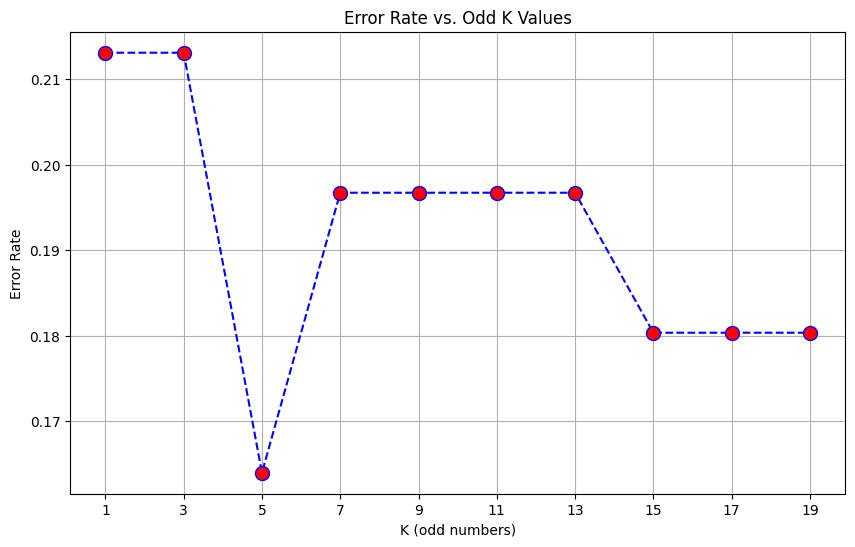

In [24]:
error_rate = []
k_values = range(1, 20, 2)   # odd numbers only

for k in k_values:
    knn = KNeighborsClassifier(
    n_neighbors=k,
    weights='distance',
    metric='minkowski',
    p=1
)
    knn.fit(X_train, y_train)
    pred_k = knn.predict(X_test)
    error_rate.append(np.mean(pred_k != y_test))

plt.figure(figsize=(10,6))
plt.plot(k_values, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

# X-axis: show odd K values
plt.xticks(k_values)

plt.title('Error Rate vs. Odd K Values')
plt.xlabel('K (odd numbers)')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()



In [39]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='minkowski',
    p=1
)

knn.fit(X_train, y_train)



,n_neighbors,5
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,1
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [46]:
# Predictions on the test set
y_pred = knn.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Detailed Classification Report (precision, recall, f1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8360655737704918
Confusion Matrix:
 [[20  8]
 [ 2 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.79      0.94      0.86        33

    accuracy                           0.84        61
   macro avg       0.85      0.83      0.83        61
weighted avg       0.85      0.84      0.83        61



61
Correct AUC (Class 0 = Heart Disease): 0.8663


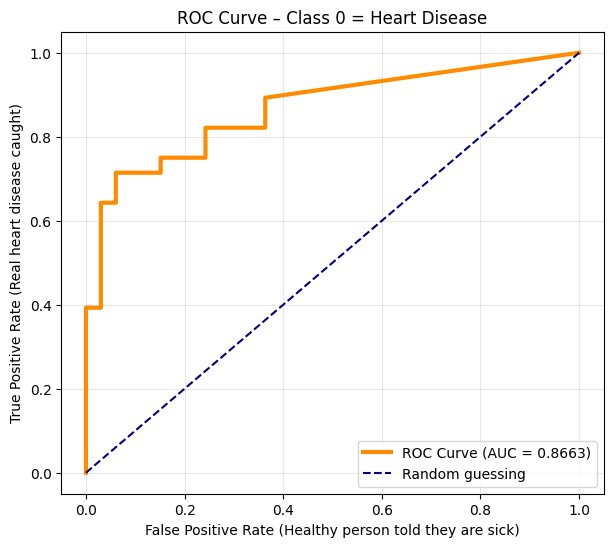

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Get the actual probabilities (not the 0/1 predictions!)
y_proba_class0 = knn.predict_proba(X_test)[:, 0]   # ← This is correct!
print(len(y_proba_class0))
# Step 2: Compute ROC and AUC for Class 0 as positive
fpr, tpr, _ = roc_curve(y_test, y_proba_class0, pos_label=0)
roc_auc = auc(fpr, tpr)

# Step 3: Print and plot
print(f"Correct AUC (Class 0 = Heart Disease): {roc_auc:.4f}")

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=3,
         label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate (Healthy person told they are sick)')
plt.ylabel('True Positive Rate (Real heart disease caught)')
plt.title('ROC Curve – Class 0 = Heart Disease')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()